In [10]:
%matplotlib inline
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
warnings.simplefilter("ignore")
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x57546000 @  0x7ff0e75692a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [11]:
train_transformation= transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_dataset=torchvision.datasets.ImageFolder(root="/content/drive/My Drive/Animals Dataset",transform=train_transformation) #path respective to requirement
classes=full_dataset.classes
trainset_length=int(0.8*len(full_dataset))
testset_length=len(full_dataset)-trainset_length
train_set,test_set=torch.utils.data.random_split(full_dataset,[trainset_length,testset_length])
print("TOTAL NO OF IMAGES GIVEN = ",len(full_dataset))
print("NO OF IMAGES UNDERGOES TRAINING =",len(full_dataset))
print("NO OF IMAGES UNDERGOES TEST=",testset_length)
dataloaders = torch.utils.data.DataLoader(full_dataset,batch_size=32,shuffle=True,num_workers=2)
testloaders = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)
dataset_sizes=len(full_dataset)
class_names=classes

TOTAL NO OF IMAGES GIVEN =  4187
NO OF IMAGES UNDERGOES TRAINING = 4187
NO OF IMAGES UNDERGOES TEST= 838


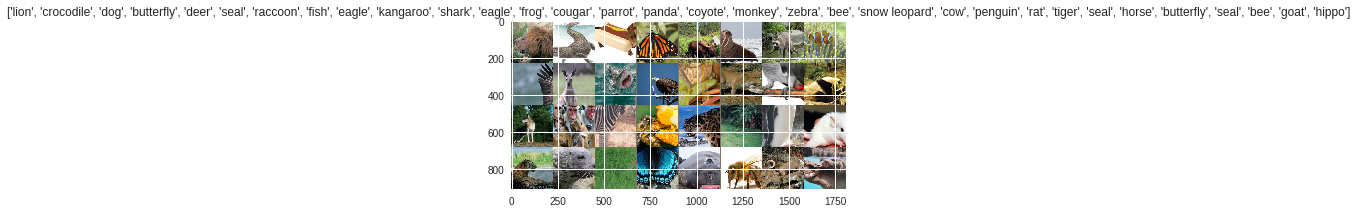

In [12]:
!pip install PILLOW==4.0.0
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
inputs, classes = next(iter(dataloaders))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes
            print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def test_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 38)  #24 for HABITATS DATASET   38 FOR ANIMALS DATASET
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=4, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
Loss: 2.4601 Acc: 0.5548

Epoch 1/9
----------
Loss: 1.1054 Acc: 0.8689

Epoch 2/9
----------
Loss: 0.7448 Acc: 0.9018

Epoch 3/9
----------
Loss: 0.5853 Acc: 0.9166

Epoch 4/9
----------
Loss: 0.4932 Acc: 0.9214

Epoch 5/9
----------
Loss: 0.4593 Acc: 0.9231

Epoch 6/9
----------
Loss: 0.4288 Acc: 0.9198

Epoch 7/9
----------
Loss: 0.3899 Acc: 0.9269

Epoch 8/9
----------
Loss: 0.3626 Acc: 0.9329

Epoch 9/9
----------
Loss: 0.3413 Acc: 0.9346

Training complete in 22m 14s
Best val Acc: 0.934559


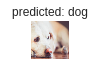

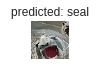

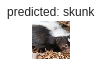

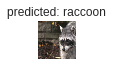

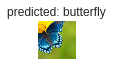

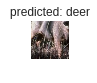

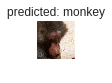

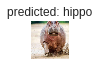

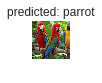

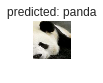

In [18]:
test_model(model_conv)

In [19]:
save_model={'class_names':class_names,'model':model_conv}
torch.save(save_model, "/content/drive/My Drive/HC#3266animal_model.pth")
print("CHECKPOINT SAVED")

CHECKPOINT SAVED


In [0]:
model_conv1=torch.load("/content/drive/My Drive/HC#3266animal_model.pth")
classes_names1=model_conv1['class_names']
model_ft=model_conv1['model']
